In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)


In [2]:
CLASS_NAMES = [
    'Early_Blight',
    'Healthy',
    'Late_Blight',
    'Leaf_Mold',
    'Septoria_Leaf_Spot'
]


In [3]:
BASE_DIR = "../dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print("Train classes:", os.listdir(TRAIN_DIR))
print("Val classes:", os.listdir(VAL_DIR))
print("Test classes:", os.listdir(TEST_DIR))


Train classes: ['Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold', 'Septoria_Leaf_Spot']
Val classes: ['Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold', 'Septoria_Leaf_Spot']
Test classes: ['Early_Blight', 'Healthy', 'Late_Blight', 'Leaf_Mold', 'Septoria_Leaf_Spot']


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=CLASS_NAMES
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=CLASS_NAMES
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=CLASS_NAMES,
    shuffle=False
)


Found 5054 images belonging to 5 classes.
Found 1081 images belonging to 5 classes.
Found 1088 images belonging to 5 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [9]:
EPOCHS = 10

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath="../model/phase1_best_model.h5",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6
)


In [11]:
history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Epoch 1/10


157/157 [==============================] - ETA: 0s - loss: 1.2179 - accuracy: 0.5301

d:\internship\project\plantenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 224s 1s/step - loss: 1.2179 - accuracy: 0.5301 - val_loss: 0.7901 - val_accuracy: 0.7443 - lr: 1.0000e-04
Epoch 2/10
157/157 [==============================] - 124s 792ms/step - loss: 0.7925 - accuracy: 0.7067 - val_loss: 0.6022 - val_accuracy: 0.8172 - lr: 1.0000e-04
Epoch 3/10
157/157 [==============================] - 124s 788ms/step - loss: 0.6432 - accuracy: 0.7630 - val_loss: 0.5033 - val_accuracy: 0.8475 - lr: 1.0000e-04
Epoch 4/10
157/157 [==============================] - 121s 772ms/step - loss: 0.5667 - accuracy: 0.7967 - val_loss: 0.4678 - val_accuracy: 0.8523 - lr: 1.0000e-04
Epoch 5/10
157/157 [==============================] - 119s 761ms/step - loss: 0.5107 - accuracy: 0.8146 - val_loss: 0.4232 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 6/10
157/157 [==============================] - 114s 728ms/step - loss: 0.4690 - accuracy: 0.8377 - val_loss: 0.3938 - val_accuracy: 0.8722 - lr: 1.0000e-04
Epoch 7/10
157/157 [================

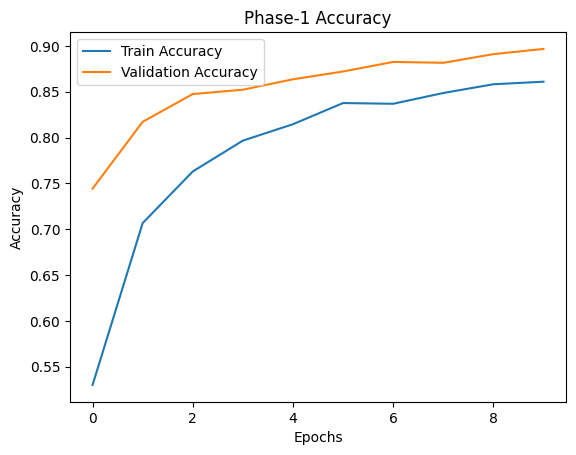

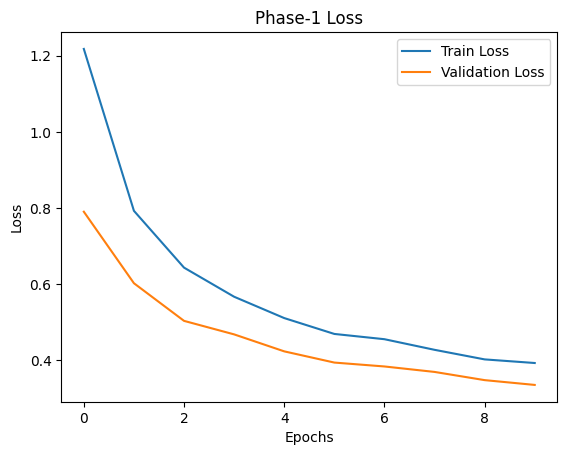

In [12]:
import matplotlib.pyplot as plt

acc = history_phase1.history['accuracy']
val_acc = history_phase1.history['val_accuracy']
loss = history_phase1.history['loss']
val_loss = history_phase1.history['val_loss']

epochs_range = range(len(acc))

plt.figure()
plt.plot(epochs_range, acc)
plt.plot(epochs_range, val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Phase-1 Accuracy")
plt.show()

plt.figure()
plt.plot(epochs_range, loss)
plt.plot(epochs_range, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Phase-1 Loss")
plt.show()


In [ ]:
# Unfreeze the top layers of MobileNetV2 
for layer in base_model.layers[-30:]: 
    layer.trainable = True

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [15]:
FINE_TUNE_EPOCHS = 6

history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/6
157/157 [==============================] - 132s 811ms/step - loss: 0.7727 - accuracy: 0.7254 - val_loss: 0.4453 - val_accuracy: 0.8466 - lr: 1.0000e-05
Epoch 2/6
157/157 [==============================] - 124s 787ms/step - loss: 0.4594 - accuracy: 0.8383 - val_loss: 0.4535 - val_accuracy: 0.8494 - lr: 1.0000e-05
Epoch 3/6
157/157 [==============================] - 124s 787ms/step - loss: 0.3976 - accuracy: 0.8560 - val_loss: 0.4652 - val_accuracy: 0.8409 - lr: 1.0000e-05
Epoch 4/6
157/157 [==============================] - 122s 776ms/step - loss: 0.3658 - accuracy: 0.8748 - val_loss: 0.4208 - val_accuracy: 0.8598 - lr: 3.0000e-06
Epoch 5/6
157/157 [==============================] - 125s 794ms/step - loss: 0.3519 - accuracy: 0.8779 - val_loss: 0.3947 - val_accuracy: 0.8646 - lr: 3.0000e-06
Epoch 6/6
157/157 [==============================] - 136s 866ms/step - loss: 0.3308 - accuracy: 0.8913 - val_loss: 0.3613 - val_accuracy: 0.8731 - lr: 3.0000e-06


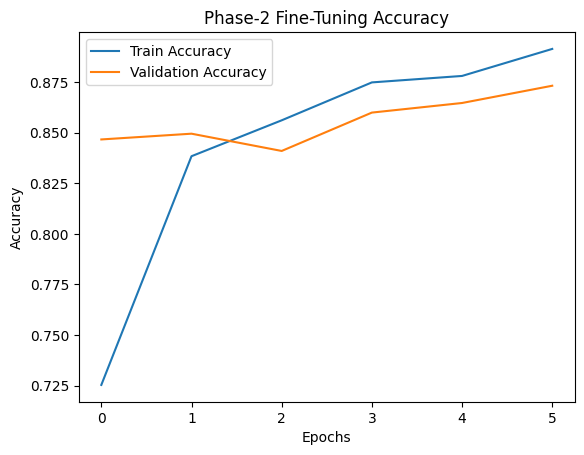

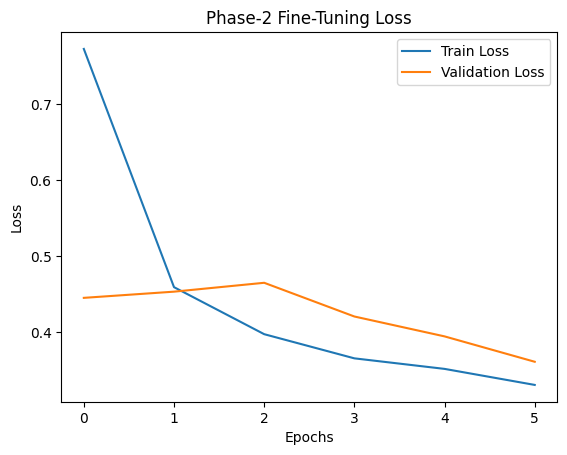

In [16]:
acc = history_phase2.history['accuracy']
val_acc = history_phase2.history['val_accuracy']
loss = history_phase2.history['loss']
val_loss = history_phase2.history['val_loss']

epochs_range = range(len(acc))

plt.figure()
plt.plot(epochs_range, acc)
plt.plot(epochs_range, val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.title("Phase-2 Fine-Tuning Accuracy")
plt.show()

plt.figure()
plt.plot(epochs_range, loss)
plt.plot(epochs_range, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.title("Phase-2 Fine-Tuning Loss")
plt.show()


In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


34/34 [==============================] - 20s 591ms/step - loss: 0.3187 - accuracy: 0.8824
Test Accuracy: 0.8823529481887817


In [18]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = y_pred_probs.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


34/34 [==============================] - 12s 338ms/step
                    precision    recall  f1-score   support

      Early_Blight       0.93      0.53      0.68       150
           Healthy       0.97      0.99      0.98       240
       Late_Blight       0.95      0.84      0.89       287
         Leaf_Mold       0.68      0.99      0.81       144
Septoria_Leaf_Spot       0.88      0.96      0.92       267

          accuracy                           0.88      1088
         macro avg       0.88      0.86      0.86      1088
      weighted avg       0.90      0.88      0.88      1088



In [19]:
model.save("../model/tomato_disease_model.h5")
print("✅ Final model saved")


d:\internship\project\plantenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Final model saved
